<img src="../../img/outlier_detection.png" alt="Outlier Detection" style="width: 100%; border-radius: 20px;"/>



##  Objective
In this notebook, as a second approach, we aim to develop machine learning models capable of identifying erroneous data points within our ornithological datasets. The primary objective of this notebook is to establish the modeling pipeline, making it easier to integrate subsequent optimizations based on our evaluation investigations.

Unlike our previous approach that primarily focused on temporal and spatial information through Emergent Filters, this machine learning approach employs anomaly detection algorithms such as DBSCAN, Isolation Forests, and AutoEncoder, which subsequently enable us to incorporate more sophisticated features, including those provided by ornitho.de (such as Atlas Code) and self-created features derived from them (like land use and altitude) into the anomaly detection process. We anticipate that the incorporation of such supplementary information will render more precise validity assessments of the data point.

## Scope
Our investigation in this notebook aims to achieve two significant outcomes. Firstly, we intend to distinguish between valid and invalid data points using afore-mentioned anomaly detection algorithms. Secondly, we aim to augment our anomaly detection process with interpretability. We employ Shapley values to unravel the decision-making process of our models, pinpointing the pivotal features that lead to the classification of a data point as erroneous. This approach not only provides valuable insights for model evaluation but also potentially provides additional assistance to reviewers during error assessment.

## Limitation
The evaluation and optimization of the employed models, including hyperparameter optimization and a finegrained feature selection, is not within the scope of this notebook since at the time this notebook was employed, no evaluation data was available. It will be conducted in the future in the chapter *04_evaluation* as part of the *Hauptprojekt*.

In [30]:
%%HTML
<style>
    body {
        --vscode-font-family: "Itim";
        font color: #d8c0b5;
    }
</style>

In [31]:
import sys
sys.path.append('../')
sys.path.append('../../')

import numpy as np
import pandas as pd
import plotly.express as px
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN
from sklearn.ensemble import IsolationForest
from pyod.models.auto_encoder import AutoEncoder

from utils.data_preparation import *

# 
<p style="background-color:#4A3228;color:white;font-size:240%;border-radius:10px 10px 10px 10px;"> &nbsp; 0️⃣ Specify your paths </p>

In order to run the notebook, the following files are required:
- Master dataset reduced to 27 species and enriched with EEA grids and land uses: *[land_use_on_coord.csv](https://drive.google.com/drive/folders/18XoTsDtWnN4QdIBNGGbq-jaa6U3nVb2e)*
- Validation dataset including unlabeled erreneous data: *[land_use_on_coord_validata_ch.csv](https://drive.google.com/drive/folders/1emvbXc5ExoEgv7Pmwy_Y5rjNc9k8hrNs)*

As output, we provide the validation dataset, where each sighting is enriched with the outlier prediction and prediction confidence of each of our three developed models, as well as the most likely error source feature.
If you wish to store it, please specify a target path.

In [32]:
path_train = '../../../01_Data/datasets/land_use_on_coord.csv'  # Provide local path to selected_species_50km_luse.csv
path_validata = '../../../01_Data/datasets/land_use_on_coord_validata_ch.csv'  # Provide local path to validata_ch_with_luse_and_gt.csv

target_path = 'model_output.csv'  # Provide local path for storing the output file

# 
<p style="background-color:#4A3228;color:white;font-size:240%;border-radius:10px 10px 10px 10px;"> &nbsp; 1️⃣ Load data </p>
For this notebook, we are using the standardized dataset containing bird sightings data from both Switzerland and Germany spanning from 2018 to 2022. It already contains our self-generated features `eea_grid_id`, `altitude`, and `land_use`.

Additionally, we apply the validation dataset provided by ornitho.ch for evaluation, comprising both correct and manually falsified data points from 2023.

In [33]:
train_data = pd.read_csv(path_train, index_col=0, low_memory=False).reset_index(drop=True)
validata = pd.read_csv(path_validata, index_col=0, low_memory=False).reset_index(drop=True)

# 
<p style="background-color:#4A3228;color:white;font-size:240%;border-radius:10px 10px 10px 10px;"> &nbsp; 2️⃣ Data preparation </p>

##  1. Data selection: The water pipit
Recognizing the intricate diversity of bird species, it becomes evident that each bird species possesses its own distinctive set of behaviors and preferences. For instance, migration times and preferred habitats exhibit substantial variations among different species.
Therefore, as discussed with the ornithologists, we refrained from training a single model for multiple species to avoid generalization errors. Instead, individualized models will be developed for each bird species. By adopting this approach, we aim to capture the specific patterns inherent to each species, ensuring that our conclusions about the validity of bird sightings are grounded in the nuanced understanding of each species' behavior.

We have chosen to prototype our model pipeline for the water pipit (ger. *Bergpieper*, depicted below), one of the 27 bird species selected by ornitho.de and ornitho.ch, as it has a medium occurrence frequency in our dataset.


<img src="https://www.lfu.bayern.de/natur/sap/arteninformationen/bild/zeige/224838" alt="A water pipit." style="border-radius: 7px;/">

As per @Samuel Wechsler, the water pipit exhibits a seasonal behavior characterized by an ascent to higher altitudes during the spring and early summer, followed by a subsequent descent back to lower elevations. The complex nature of the water pipit's migratory behavior introduces complexity, requiring algorithms to capture the nuanced patterns associated with the water pipit's seasonal altitude variations. 

In [34]:
bergpieper_train = train_data[train_data.name_species == 'Bergpieper']
bergpieper_test = validata[validata.name_species == 'Bergpieper']

In [35]:
bergpieper_train.head(2)

,id_sighting,id_species,name_species,date,timing,coord_lat,coord_lon,precision,altitude,total_count,atlas_code,id_observer,country,eea_grid_id,Code_18,land_use_coord,land_use_coord_numeric
12,29658979,469.0,Bergpieper,2018-01-01,NaN,52.321750,10.432800,place,65,2.0,NaN,106288.0,de,50kmE4350N3200,231.0,agriculture,3
30,29661644,469.0,Bergpieper,2018-01-01,NaN,49.144776,10.690435,square,414,3.0,NaN,70588.0,de,50kmE4350N2850,231.0,agriculture,3


In [36]:
bergpieper_test.head(2)

,id_validata,id_sighting,id_species,name_species,date,timing,coord_lat,coord_lon,precision,altitude,total_count,atlas_code,id_observer,eea_grid_id,Code_18,land_use_coord,land_use_coord_numeric
16,17,NaN,469,Bergpieper,2023-07-10,NaN,47.567153,7.551575,square,280,10.0,0,9110,50kmE4100N2700,242,agriculture,3
509,510,NaN,469,Bergpieper,2023-03-25,10:02:32,46.155468,8.865485,precise,190,1.0,0,1504,50kmE4200N2550,411,wetlands,13


## 2. Feature selection
Not all features in the dataset depicted above are considered suitable or informative for the outlier analysis. Consequently, we exclude the following features from consideration, as they do not provide additional information for assessing validity:
- `id_validata`
- `id_sighting`
- `id_species`
- `name_species`
- `precision`
- `id_observer`

Furthermore, we exclude highly sparse features, as outlier detection algorithms may misinterpret these sparse features as indicative of unusual behavior, leading to false positives and reduced overall accuracy. Therefore, the features `timing` (59.3% unspecified) and `atlas_code` (78.1.% unspecified) are excluded due to their sparsity:

In [37]:
print('Percentage of unspecified timing feature:', train_data.timing.isna().sum() / len(train_data))
grouped_atlas_codes = condense_atlas_codes(train_data.atlas_code)
print('Percentage of unspecified atlas code feature:', (grouped_atlas_codes == 0).sum() / len(train_data))

Percentage of unspecified timing feature: 0.5928272588074704
Percentage of unspecified atlas code feature: 0.780635501005059


As part of the *Hauptprojekt*, these sparse features can be included to evaluate their influence.

For building the modeling pipeline, we also omit `eea_grid_id`, as the spatial information is also already depicted in `coord_lat` and `coord_lon`. A comparison of which representation leads to better results will be conducted as part of the *Hauptprojekt*.

Lastly, we remove `land_use_coord` as it holds the same information as `land_use_coord_numeric` but as string literals.

All other features will be incorporated to our outlier analysis:

In [38]:
bergpieper_train = bergpieper_train[['date', 'coord_lat', 'coord_lon', 'altitude', 'total_count','land_use_coord_numeric']]
bergpieper_test = bergpieper_test[['date', 'coord_lat', 'coord_lon', 'altitude', 'total_count', 'land_use_coord_numeric']]
bergpieper_train.head()

,date,coord_lat,coord_lon,altitude,total_count,land_use_coord_numeric
12,2018-01-01,52.321750,10.432800,65,2.0,3
30,2018-01-01,49.144776,10.690435,414,3.0,3
39,2018-01-01,51.022837,6.208935,48,1.0,3
41,2018-01-01,51.022837,6.208935,48,1.0,3
44,2018-01-01,49.872006,12.239931,470,2.0,3


## 3. Feature preparation
Before modeling with the data, some preparatory steps need to be taken:

Each date is converted to its respective day of year to convert it to a numerical value.

In [39]:
# Turn date into day of year
bergpieper_train.date = pd.to_datetime(bergpieper_train.date).dt.dayofyear
bergpieper_test.date = pd.to_datetime(bergpieper_test.date).dt.dayofyear

The `land_use` feature is a categorical feature. To prevent models from assuming an ordinal relationship between the land use categories, one-hot encoding is applied, creating binary columns for each distinct land use category.

In [40]:
# One-hot-encode land use feature
land_uses = bergpieper_train['land_use_coord_numeric'].unique()
bergpieper_train = pd.get_dummies(bergpieper_train, columns=['land_use_coord_numeric'], dtype=int)
bergpieper_test = pd.get_dummies(bergpieper_test, columns=['land_use_coord_numeric'], dtype=int)

# Add missing land use categories to test set
for land_use in land_uses:
    category = 'land_use_coord_numeric_' + str(land_use)
    if category not in bergpieper_test.columns:
        bergpieper_test[category] = 0

# Ensure that both df's are sorted equally
bergpieper_train = bergpieper_train.reindex(sorted(bergpieper_train.columns), axis=1)
bergpieper_test = bergpieper_test.reindex(sorted(bergpieper_test.columns), axis=1)

For better interpretability, we also rename all `land_use` feature columns with their respective land use instead of numericals.

In [41]:
land_use_mapping = {
    1: 'urban',
    2: 'industrial',
    3: 'agriculture',
    4: 'forest',
    5: 'grassland',
    6: 'mediterranean_vegetation',
    7: 'shrubland',
    8: 'coastal',
    9: 'rocky_area',
    10: 'sparsely_vegetated',
    11: 'burnt_area',
    12: 'glacier',
    13: 'wetlands',
    14: 'water',
    15: 'unclassified_land',
    16: 'unclassified_water',
    17: 'unclassified'
}

# Iterate through columns and replace values
for df in [bergpieper_train, bergpieper_test]:
    for col in df.columns:
        if col.startswith('land_use_coord_numeric_'):
            number = int(col.split('_')[-1])
            key = land_use_mapping.get(number, f'unknown_{number}')
            new_col = col.replace(f'land_use_coord_numeric_{number}', f'luse_{key}')
            df.rename(columns={col: new_col}, inplace=True)

Further, if no information is provided by the user regarding the bird count, it is assumed that a single bird was observed. Therefore, all NaN values in the column `total_count` are set to 1:

In [42]:
# Replace NaNs in total_count with 1 (default value)
bergpieper_train.total_count = bergpieper_train.total_count.fillna(1)
bergpieper_test.total_count = bergpieper_test.total_count.fillna(1)

Lastly, a Min-Max-Normalization is performed for all features. Outlier detection relies on distance or density-based measures, making the algorithms sensitive to the scale of features. MinMax scaling addresses this sensitivity by transforming features to a standardized range from 0-1, ensuring that each feature contributes equally to distance metrics. This not only enhances algorithmic efficiency and robustness by preventing one feature from dominating the analysis but also promotes a uniform convergence of the optimization process during training.

In [43]:
# Normalize features between 0 and 1
scaler = MinMaxScaler()
bergpieper_train = pd.DataFrame(scaler.fit_transform(bergpieper_train), columns=bergpieper_train.columns)
bergpieper_test = pd.DataFrame(scaler.fit_transform(bergpieper_test), columns=bergpieper_test.columns)

The final training and testing datasets are now structured as follows:

In [72]:
bergpieper_train.head(2)

,altitude,coord_lat,coord_lon,date,luse_urban,luse_sparsely_vegetated,luse_burnt_area,luse_glacier,luse_wetlands,luse_water,luse_unclassified,luse_industrial,luse_agriculture,luse_forest,luse_grassland,luse_shrubland,luse_coastal,luse_rocky_area,total_count
0,0.021799,0.697950,0.509848,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.002151
1,0.118102,0.359307,0.537404,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.003226


In [73]:
bergpieper_test.head(2)

,altitude,coord_lat,coord_lon,date,luse_urban,luse_sparsely_vegetated,luse_burnt_area,luse_glacier,luse_wetlands,luse_water,luse_unclassified,luse_industrial,luse_agriculture,luse_forest,luse_grassland,luse_shrubland,luse_coastal,luse_rocky_area,total_count
0,0.023166,0.877276,0.344340,0.524862,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.023810
1,0.000000,0.160889,0.639727,0.229282,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002381


# 
<p style="background-color:#4A3228;color:white;font-size:240%;border-radius:10px 10px 10px 10px;"> &nbsp; 3️⃣ Modeling </p>

Our objective is to formulate an outlier detection model proficient in identifying bird sightings that deviate from the species' norms. This model will be exclusively trained on valid data points spanning from 2018 to 2022. Subsequently, we will assess its proficiency in identifying outliers using a curated test dataset from 2023 which has been augmented with anomalies introduced by the ornithologists.

Three commonly used outlier algorithms will be trained: DBSCAN, Isolation Forest, and AutoEncoder, initially with non-optimized hyperparameters that yield satisfactory results. These can be tuned and adjusted in a subsequent deep-dive as part of the *Hauptprojekt*. After training, the models predict whether a data point in the validation dataset is an valid (=0) or possibly faulty (=1). For each algorithm, the percentage of recognized outlier models is returned.

## 1. DBSCAN
DBSCAN (Density-Based Spatial Clustering of Applications with Noise) partitions data points into clusters by assessing their local density to neighboring points, designating points in areas of lower density as outliers. It excels in capturing both dense and sparse regions, making it adaptable to the varied data densities commonly encountered. Given the varying spatial densities observed in our bird dataset, it is aspired that DBSCAN will be capable of considering variable local densities and capturing isolated bird sightings.

The parameter choice of a DBSCAN algorithm heavily influences its performance. However, without ground truth evaluation labels, these parameters can not be configured optimally. Initially, we will set the minimum number of data points required to forme a cluster to five sightings, and the maximum distance between two samples for one to be considered in the neighborhood of the other to 0.1, as these follow general guidelines and yield satisfactory results.

In [46]:
dbscan = DBSCAN(eps=0.1, min_samples=5)
labels = dbscan.fit(bergpieper_train)
prediction_dbscan = dbscan.fit_predict(bergpieper_test)  # outliers=-1
prediction_dbscan[prediction_dbscan > 0] = 0  # inliers=0
prediction_dbscan[prediction_dbscan == -1] = 1  # outliers=1

outliers_dbscan = bergpieper_test[prediction_dbscan == 1]

print('Number of detected anomalies:', len(outliers_dbscan), '/', len(bergpieper_test))
print('Percentage of anomalies:', round(len(outliers_dbscan)/len(bergpieper_test)*100,2), '%')

Number of detected anomalies: 417 / 6431
Percentage of anomalies: 6.48 %


## 2. Isolation Forest
An Isolation Forest is an ensemble machine learning algorithm designed for outlier detection. It operates on the principle that anomalies are easier to isolate than normal instances. Anomalies, being less frequent, are isolated more quickly and appear closer to the root of the trees.

As a hyperparameter choice, we set the contamination to 0.01, as we expect a 1% outlier percentage in the dataset.

In [47]:
# calling Isolation Forest with contamination != 'auto' leads to a sklearn bug; see https://github.com/scikit-learn/scikit-learn/issues/25844
import warnings
warnings.filterwarnings("ignore")

In [48]:
isolation_forest = IsolationForest(contamination=0.01, random_state=0)
isolation_forest.fit(bergpieper_train)

prediction_if = isolation_forest.predict(bergpieper_test)
prediction_if[prediction_if == 1] = 0  # inliers = 0
prediction_if[prediction_if == -1] = 1  # outliers = 1

outliers_if = bergpieper_test[prediction_if == 1]

print('Number of detected anomalies:', len(outliers_if), '/', len(bergpieper_test))
print('Percentage of anomalies:', round(len(outliers_if)/len(bergpieper_test)*100,2), '%')

Number of detected anomalies: 203 / 6431
Percentage of anomalies: 3.16 %


## 3. AutoEncoder
An autoencoder is a type of artificial neural network used for unsupervised learning and dimensionality reduction. It consists of an encoder and a decoder, with the encoder compressing the input data into a lower-dimensional representation, and the decoder reconstructing the original input from this representation. In the context of outlier detection, the autoencoder is trained on normal instances, learning to reconstruct them accurately. Anomalies, being deviations from the learned patterns, result in higher reconstruction errors. During testing, instances with significantly higher reconstruction errors are considered outliers.

As a baseline model, an AutoEncoder with an input layer with 17 neurons is trained, each corresponding to an input feature. The hidden layers gradually decrease the number of neurons from eight to six (bottleneck layer), forcing the network to learn a compressed representation of the input. The output layer has the same number of neurons as the input layer.

In [49]:
ae = AutoEncoder(hidden_neurons=[17, 8, 6, 8, 17], batch_size=256, epochs=10, verbose=0)
ae.fit(bergpieper_train)
display(ae.get_params())

prediction_ae = ae.predict(bergpieper_test)  # inliers=0; outliers=1
outliers_ae = bergpieper_test[prediction_ae == 1]

print('Number of detected anomalies:', len(outliers_ae), '/', len(bergpieper_test))
print('Percentage of anomalies:', round(len(outliers_ae)/len(bergpieper_test)*100,2), '%')

3370/3370 [==============================] - 8s 2ms/step


{'batch_size': 256,
 'contamination': 0.1,
 'dropout_rate': 0.2,
 'epochs': 10,
 'hidden_activation': 'relu',
 'hidden_neurons': [17, 8, 6, 8, 17],
 'l2_regularizer': 0.1,
 'loss': <function keras.src.losses.mean_squared_error(y_true, y_pred)>,
 'optimizer': 'adam',
 'output_activation': 'sigmoid',
 'preprocessing': True,
 'random_state': None,
 'validation_size': 0.1,
 'verbose': 0}

201/201 [==============================] - 0s 2ms/step
Number of detected anomalies: 1149 / 6431
Percentage of anomalies: 17.87 %



# 
<p style="background-color:#4A3228;color:white;font-size:240%;border-radius:10px 10px 10px 10px;"> &nbsp; 4️⃣ Add interpretability with Shapley </p>
In order to gain an initial insight into the internal functioning of the models, we employ Shapley values. Shapley values offer a systematic methodology for comprehending the significance of features within the model's decision-making process.

Additionally, we aim to utilize Shapley values to identify, on a per-data-point basis, which feature has predominantly contributed to the model categorizing a data point as an outlier. This approach could assist reviewers in pinpointing the potential source of error within the data point.

## 1. Feature importance across all data points
The summary plot provides an overview of the feature importance for each feature in the model's predictions, where the vertical bars represent the mean magnitude of the SHAP values for each feature. 

Instead of evaluating feature importance for the entire dataset, SHAP values are typically computed for a randomly sampled subset. This approach balances between the duration of the calculation and the accuracy of the results. In this case, 200 bird sightings are sampled for the SHAP calculation.

It can be observed that the feature relevance varies considerably among the models. In our investigation of outlier detection models trained on the same dataset, we observed notable disparities in feature importances. These distinctions can be attributed to a combination of algorithmic variances, such as the inherent principles guiding DBSCAN, Isolation Forest, and AutoEncoder, as well as the impact of model hyperparameters.

DBSCAN assigns high importance to both latitude and longitude values, as well as the date and altitude. Similarly, Isolation Forest demonstrates a comparable emphasis, albeit with overall less relevance. Both models attribute significant importance to various land uses, with `grassland` appearing particularly crucial for both.

In contrast, the AutoEncoder distinguishes itself from the other models by predominantly utilizing land uses for discerning between inliers and outliers. Unlike the other two models, the relevance of other features such as date, sighting location, and sighting altitude is notably less significant.

The informativeness of a feature provides insights into which features were influential for model predictions. However, it needs to be emphasized that the conclusions drawn based on these features may not necessarily be accurate. Once labeled data is accessible, it can be verified whether the outliers identified through these influential features were correctly recognized, and assumptions can be made accordingly.

In [50]:
samples_bergpieper_test = bergpieper_test.sample(n=200, random_state=42)

In [ ]:
explainer_db = shap.Explainer(dbscan.fit_predict, bergpieper_test)
shap_values_dbscan = explainer_db.shap_values(samples_bergpieper_test)

In [52]:
explainer_if = shap.Explainer(isolation_forest, bergpieper_test)
shap_values_if = explainer_if.shap_values(samples_bergpieper_test)

In [ ]:
explainer_ae = shap.Explainer(ae.predict, bergpieper_test)
shap_values_ae = explainer_ae.shap_values(samples_bergpieper_test)

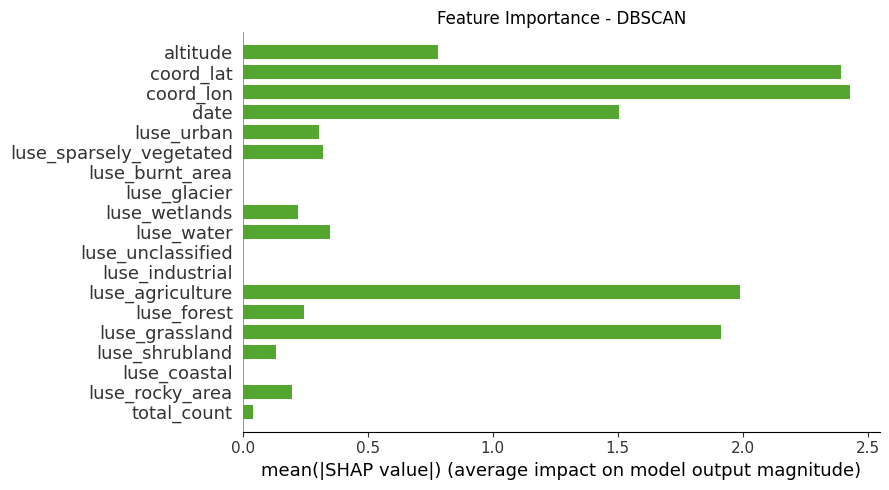

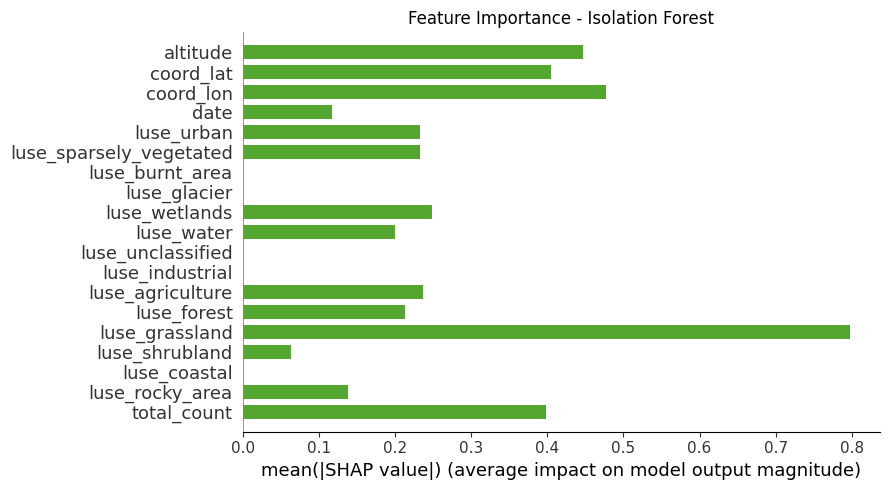

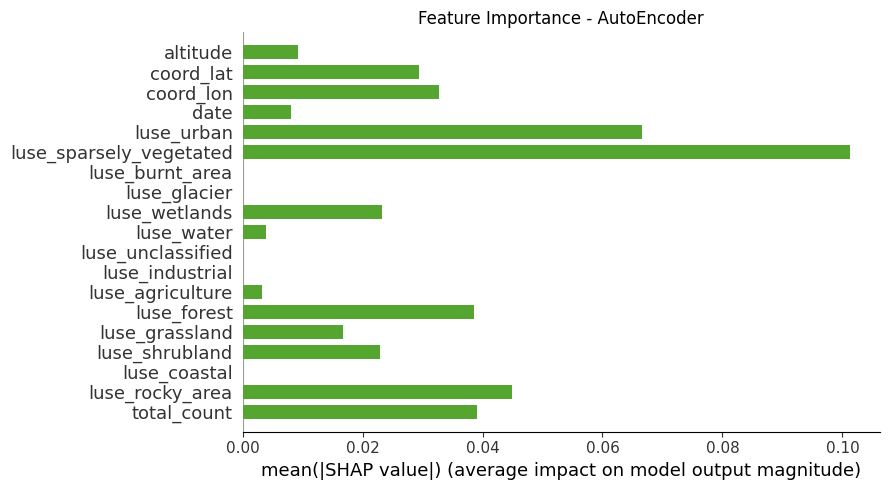

In [54]:
for shap_values, name in zip([shap_values_dbscan, shap_values_if, shap_values_ae], ['DBSCAN', 'Isolation Forest', 'AutoEncoder']):
    plt.title('Feature Importance - ' + name)
    shap.summary_plot(shap_values, bergpieper_test, plot_type='bar', color='#55a630', plot_size=(9, 5), sort=False)

## 2. Feature importance for a specific data point

With Shapley, it is also possible to display a bar plot specifically illustrating the contribution of individual features to the prediction for that particular data point.
From the plot, we can derive:
- **Feature Importance Magnitude:** The height of each bar represents the magnitude of the SHAP values for a specific feature with respect to the prediction for the given data point. A taller bar indicates a feature's higher impact on the prediction for that specific instance.

- **Direction of Impact:** The color of the bars can indicate the direction of the impact of each feature on the prediction. Positive impact (features contributing to an outlier) might be a different color from negative impact (features contributing to an inlier).

Below, a singular sighting of a water pipit is selected, and a Shapley bar plot is generated for each model. The Bergpieper is sighted in the midth of July on a field near Basel at the French border in northern Switzerland:

<img src="../../img/bergpieper_example.png" alt="Outlier Detection" style="width: 40%; border-radius: 20px;"/>

In [55]:
display(validata[validata.name_species == 'Bergpieper'].iloc[0])

id_validata                           17
id_sighting                          NaN
id_species                           469
name_species                  Bergpieper
date                          2023-07-10
timing                               NaN
coord_lat                      47.567153
coord_lon                       7.551575
precision                         square
altitude                             280
total_count                         10.0
atlas_code                             0
id_observer                         9110
eea_grid_id               50kmE4100N2700
Code_18                              242
land_use_coord               agriculture
land_use_coord_numeric                 3
Name: 16, dtype: object

This datapoint was labeled as outlier by DBSCAN; Isolation Forest and AutoEncoder labeled it as inlier:

In [56]:
print('Datapoint prediciton of DBSCAN:', prediction_dbscan[0])
print('Datapoint prediciton of Isolation Forest:', prediction_if[0])
print('Datapoint prediciton of AutoEncoder:', prediction_ae[0])

Datapoint prediciton of DBSCAN: 1
Datapoint prediciton of Isolation Forest: 0
Datapoint prediciton of AutoEncoder: 0


As can be seen below, similar to the feature importances across the entire dataset, both the magnitudes and the directional impact of these features exhibit considerable variation, attributable to distinct algorithmic approaches and hyperparameter settings. Therefore, it is anticipated that distinct label behaviors may be observed during evaluation in the *Hauptprojekt*.

For instance, the water pipit was sighted on land `agriculture`, which consistently indicates an inlier across all three models. Considering both Germany and Switzerland, the water pipit sighting is about centrally located. However, the `latitude` value demonstrates high magnitudes for all models. It also shows opposing directions of impact in the Isolation Forest when compared to the other two models. 

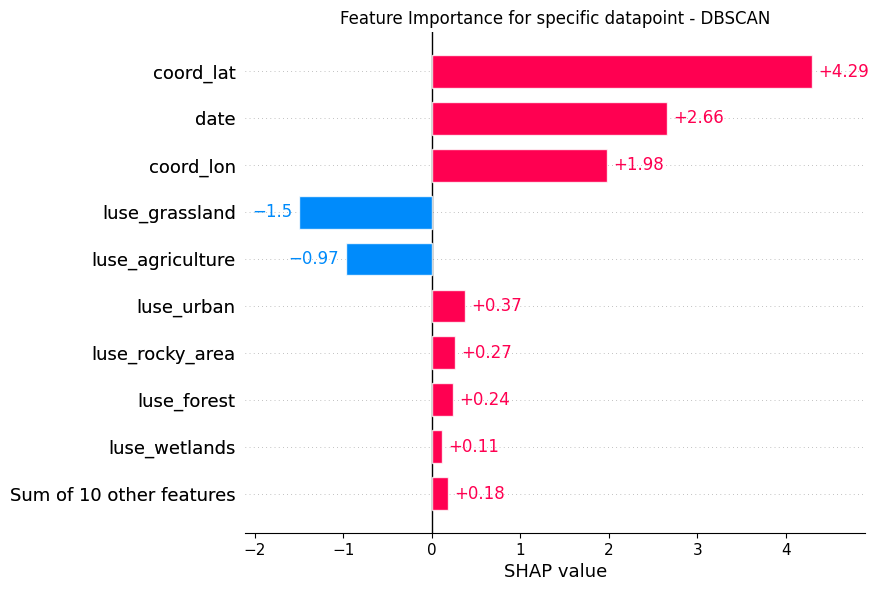

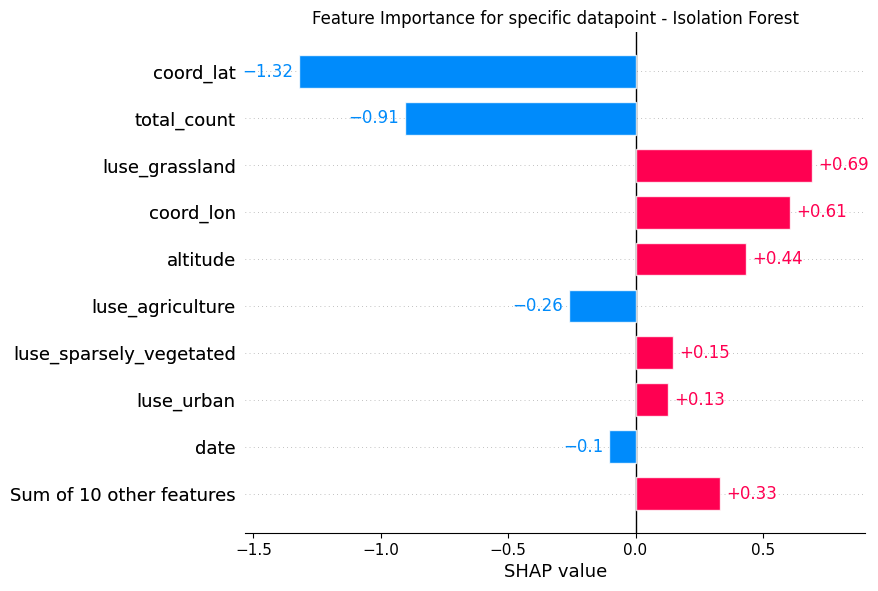

42/42 [==============================] - 0s 2ms/step


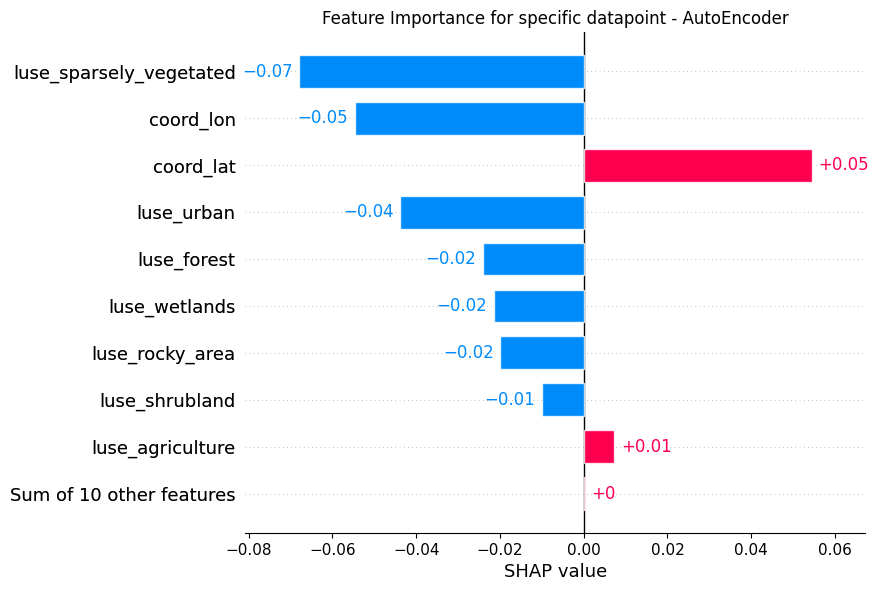

In [57]:
for shap_explainer, name in zip([explainer_db, explainer_if, explainer_ae], ['DBSCAN', 'Isolation Forest', 'AutoEncoder']):
    plt.title('Feature Importance for specific datapoint - ' + name)
    shap_values = shap_explainer(bergpieper_test[0:1])
    shap.plots.bar(shap_values[0])

## 3. Takeaway 
The Shapley analysis indicates that the three models prioritize different features and also demonstrate different directions of impact for the same data point. This variability can be attributed to differences in the internal mechanisms of the models and non-optimized hyperparameters. The evaluation during the *Hauptprojekt* may reveal which model establishes the best prioritizations.

# 
<p style="background-color:#4A3228;color:white;font-size:240%;border-radius:10px 10px 10px 10px;"> &nbsp; 5️⃣ Output generation</p>

As an output, we append the outlier predictions of the models to the original validation dataset, along with complimentary features that will enable a more comprehensive evaluation.

In [58]:
bergpieper_output = validata[validata.name_species == 'Bergpieper'].copy()

## 1. Add predictions
First, the validation dataset is enriched with the binary predictions of the models, where a 1 denotes that the model detected an outlier.

In [59]:
# Add outlier prediction
bergpieper_output['error_detected_dbscan'] = prediction_dbscan
bergpieper_output['error_detected_if'] = prediction_if
bergpieper_output['error_detected_ae'] = prediction_ae

## 2. Add most likely error source
Also, to deliver the name of the feature that contributed the most to the datapoint being labeled as outlier, an additional column per model is introduced. In the event of an outlier, this column captures the feature associated with the most negative Shapley value (i.e., the most likely error source).

In [ ]:
feature_names = bergpieper_test.columns
outlier_shaps_dbscan = explainer_db.shap_values(outliers_dbscan)
outlier_shaps_if = explainer_if.shap_values(outliers_if)
outlier_shaps_ae = explainer_ae.shap_values(outliers_ae)

In [61]:
for shaps, error_col, target_col in zip([outlier_shaps_dbscan, outlier_shaps_if, outlier_shaps_ae], 
                                        ['error_detected_dbscan', 'error_detected_if', 'error_detected_ae'], 
                                        ['most_likely_error_source_dbscan', 'most_likely_error_source_if', 'most_likely_error_source_ae']):
    error_sources = []
    for shap_values in shaps:
        feature_index = np.argmin(shap_values)
        feature_name = feature_names[feature_index]
        error_sources.append(feature_name)
    mask = bergpieper_output[error_col] == 1
    bergpieper_output.loc[mask, target_col] = error_sources
    bergpieper_output.loc[~mask, target_col] = None

## 3. Add the model's prediction confidence
Lastly, information about the predictions confidence is added, which can be extracted from the decision function of the model.

In the context of an Isolation Forest and the AutoEncoder, the decision function score represents the anomaly score for a data point. Its magnitude captures the likelihood of the data point being an outlier according to the model.

Unlike Isolation Forests and AutoEncoder, DBSCAN models do not inherently offer a decision function to assess the anomaly or normalcy of data points. Therefore, these values are not generated for the DBSCAN model.

In [62]:
bergpieper_output['anomaly_score_forest'] = isolation_forest.decision_function(bergpieper_test)

In [63]:
bergpieper_output['anomaly_score_autoencoder'] = ae.decision_function(bergpieper_test)

201/201 [==============================] - 0s 1ms/step


## 4. Store the results as csv
The final output is stored under the provided path:

In [64]:
bergpieper_output.to_csv(target_path)

## 5. The final output structure

In [74]:
bergpieper_output.head()

,id_validata,id_sighting,id_species,name_species,date,timing,coord_lat,coord_lon,precision,altitude,...,land_use_coord,land_use_coord_numeric,error_detected_dbscan,error_detected_if,error_detected_ae,most_likely_error_source_dbscan,most_likely_error_source_if,most_likely_error_source_ae,anomaly_score_forest,anomaly_score_autoencoder
16,17,NaN,469,Bergpieper,2023-07-10,NaN,47.567153,7.551575,square,280,...,agriculture,3,1,0,0,luse_grassland,None,None,0.081428,3.569623
509,510,NaN,469,Bergpieper,2023-03-25,10:02:32,46.155468,8.865485,precise,190,...,wetlands,13,0,0,0,None,None,None,0.060021,4.389159
510,511,NaN,469,Bergpieper,2023-04-14,18:24:20,46.162629,8.857722,precise,190,...,wetlands,13,0,0,0,None,None,None,0.057853,4.353612
511,512,NaN,469,Bergpieper,2023-03-18,08:00:42,46.163578,8.855934,precise,190,...,water,14,0,0,0,None,None,None,0.107884,3.228221
512,513,NaN,469,Bergpieper,2023-01-31,13:31:02,46.162629,8.857658,precise,190,...,wetlands,13,0,0,0,None,None,None,0.047664,4.493923


# 
<p style="background-color:#4A3228;color:white;font-size:240%;border-radius:10px 10px 10px 10px;"> &nbsp; 6️⃣ Initial model assessment - Visualizing the results </p>

As a first initial assessment of the models results, we will provide a visual representation of the model's predictions.

## 1. Distribution of outliers per feature
The pairplots below show the relationship between pairs of features in a dataset for each model. The diagonal plots show the univariate distribution of each feature.

For better readability of the pairplots, we invert the one-hot encoding of the land use feature:

In [65]:
# Reverse one-hot-encoding of land use feature
bergpieper_outlier_distribution = bergpieper_test.copy()
bergpieper_outlier_distribution['land_use'] = bergpieper_outlier_distribution.filter(like='luse').idxmax(axis=1).str.replace('luse_', '')
bergpieper_outlier_distribution['land_use'] = bergpieper_outlier_distribution['land_use'].map({v: k for k, v in land_use_mapping.items()})
bergpieper_outlier_distribution = bergpieper_outlier_distribution.drop(bergpieper_outlier_distribution.filter(like='luse_').columns, axis=1)
bergpieper_outlier_distribution['land_use'] = scaler.fit_transform(bergpieper_outlier_distribution[['land_use']])

In [66]:
def show_pairplot(predictions, title, palette):
    bergpieper_pred = bergpieper_outlier_distribution.copy()
    bergpieper_pred['Error Detected?'] = predictions
    bergpieper_pred['Error Detected?'] = bergpieper_pred['Error Detected?'].replace({0:'Datapoint OK', 1: 'Outlier'})
    g = sns.pairplot(bergpieper_pred, hue='Error Detected?', palette=palette, height=1, plot_kws={"s": 4})
    g.fig.suptitle(title, y=1.05, fontsize=24)

### DBSCAN
We can observe that DBSCAN is particularly effective in identifying the outliers in the date feature. This aligns with the DBSCAN's shap values, which indicated that it attributes significant relevance to the date feature. Additionally, points with a high altitude or an unusually high bird count are consistently identified as outliers. As seen in the univariate distributions, the latitude and longitude values for both outliers and inliers fall within the same range. Nevertheless, they form light clusters, which could be the reason for the high Shapley values. The land also fall within the same range if considering the univariate distribution. Distinguishing between them based solely on the land use features therefore appears challenging.

Notably, a trumpet shape of the date/altitude plot can be observed. As per @Samuel Wechsler, the water pipit ascends to higher altitudes in the spring / early summer and later returns to lower areas. DBSCAN can correctly capture this temporal pattern, as the bird sighting density of the water pipit shifts to higher altitudes throughout the year. Consequently, water pipits present in low areas in late spring are sparsely observed.

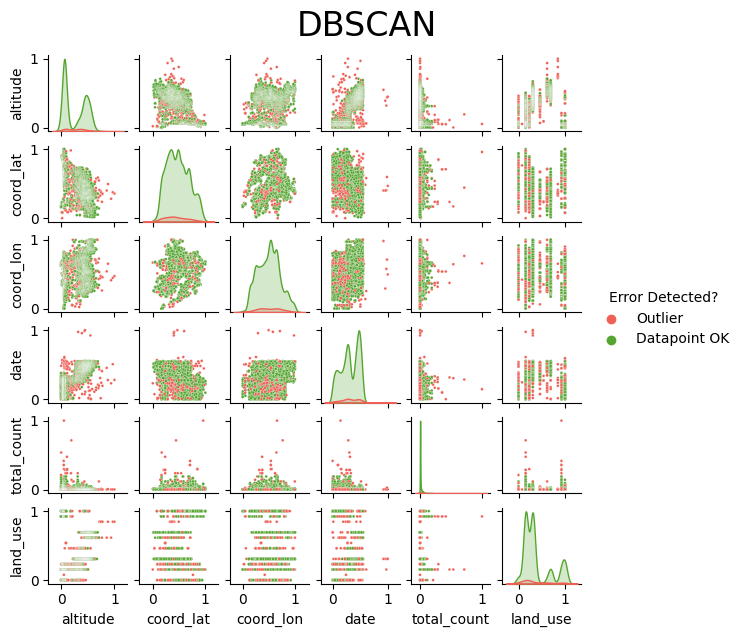

In [67]:
show_pairplot(prediction_dbscan, 'DBSCAN', palette=['#ee6055', '#55a630'])

### Isolation Forest
With the Isolation Forest, a lower outlier rate is observed. In line with its low relevance according to the SHAP values, outlying dates are rarely discovered. It is crucial to note that, even though the date points in the test data are significantly outside the range of 0-200, the training data encompasses data points throughout the entire year. Therefore, it is valid that a point at days 200-300 may not be promptly flagged.

High values of the features `total_count` and `altitude` can be partially noticed as outliers by the Isolation Forest.

The Isolation Forest is further not capable to capture the trumpet shape of the water pipit's altitudal travels.

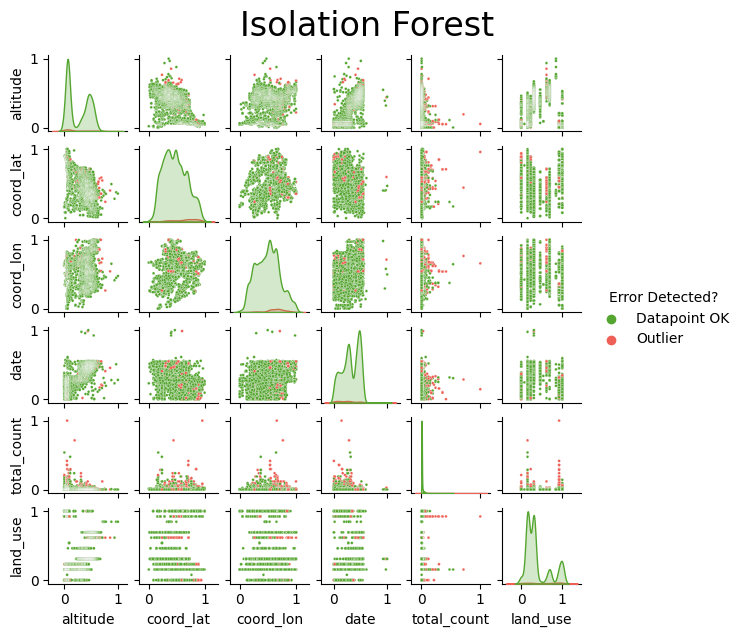

In [68]:
show_pairplot(prediction_if, 'Isolation Forest', palette=['#55a630', '#ee6055'])

### AutoEncoder
The AutoEncoder identifies 17.88% of all sightings in the test dataset as outlier. Similar to the Isolation Forest, the date points are not promptly flagged, whereas outliers in the `total_count` and the `altitude` feature are labeled as such.

The trumpet shape is partially captured. During times when the bird is at lower altitudes, highly localized birds are flagged. However, birds observed at lower altitudes go unnoticed during periods when they are typically seen at higher elevations.

Notably, for some land uses, sightings are always marked as outliers, including 7 (shrublands), 8 (coastal), 9 (rocky_area), 10 (sparsely_vegetated), and 12 (glacier). Hypotheses about this, and whether these points are indeed outliers, can be made upon receiving the ground truth labels.

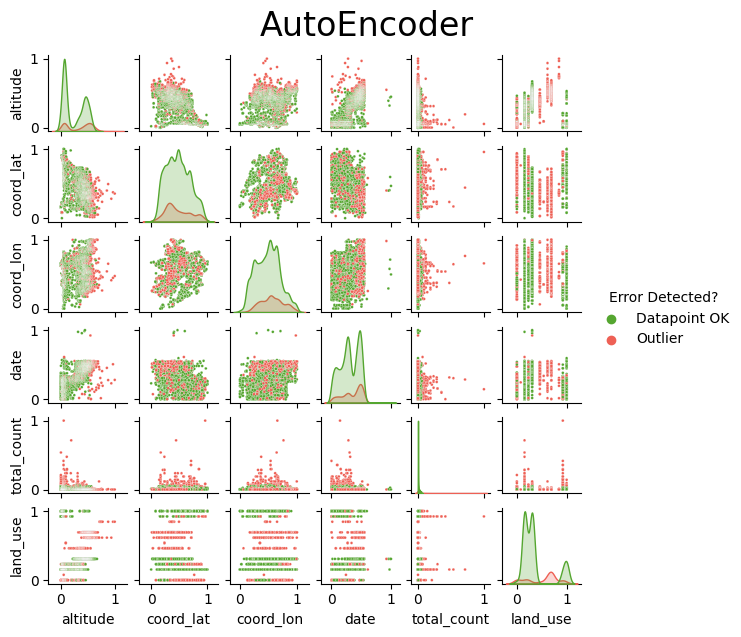

In [69]:
show_pairplot(prediction_ae, 'AutoEncoder', palette=['#55a630', '#ee6055'])

## 2. Distribution of most likely error sources
In the plots below, the distributions of the most likely error sources (i.e., most negative Shap values) for the outliers are depicted.

For all three algorithms, in the case of an outlier, the land use features appear to frequently exhibit the most negative magnitudes. This trend is particularly pronounced in the AutoEncoder, as already evident in the pairplots shown above. In the case of Isolation, `total_count` is among the features with the most negative Shapley values, which aligns with its high feature importance.

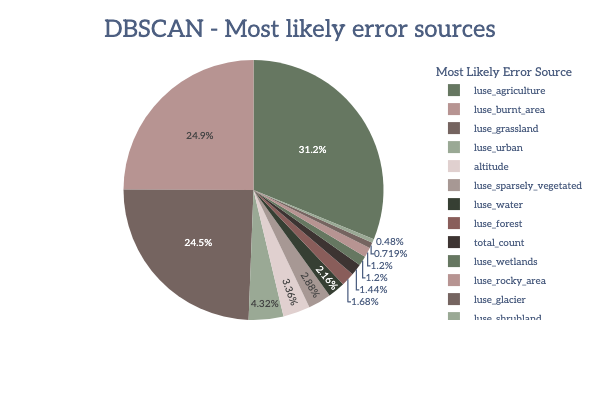

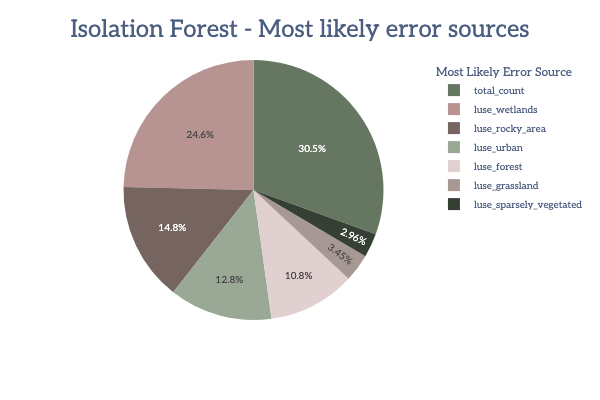

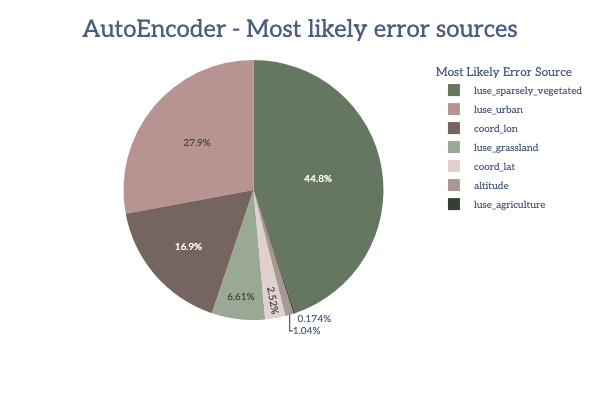

In [76]:
for error_sources, name in zip(['most_likely_error_source_dbscan', 'most_likely_error_source_if', 'most_likely_error_source_ae'], ['DBSCAN', 'Isolation Forest', 'AutoEncoder']):
    value_counts = bergpieper_output[error_sources].value_counts()
    fig = px.pie(names=value_counts.index, values=value_counts.values, 
                color_discrete_sequence=['#667761', '#b79492', '#756460'])
    fig.update_layout(font=dict(family="Aleo", size=10, color="#4d5f81"),
                    title=dict(x=0.5, y=0.95, font=dict(size=24), text=name+' - Most likely error sources', xanchor='center'),
                    legend_title_text='Most Likely Error Source',
                    width=600, height=400)
    fig.show()

## 3. Distribution of the model's anomaly scores
The decision function provides insights into the prediction confidence of the model. 

In the case of the Isolation Forest, values below 0 are deemed outliers. The farther the value is from zero, the greater the model's confidence. It can be observed that the confidences are roughly distributed in a normal distribution around ~0.07.

For the AutoEncoder, higher values correspond to higher confidence in identifying an outlier. The normal distribution is also evident in the AutoEncoder; however, a few outliers are situated far from the mean in this case. 

Additionally, a significant number of inliers have been labeled as such with low confidence by both models. To mitigate the occurrence of false negatives (where a data point is incorrectly labeled as correct), the threshold could be increased from 0 to a higher value. This adjustment would entail labeling inliers, identified with low confidence, as outliers as well. This modification is planned for a subsequent study.

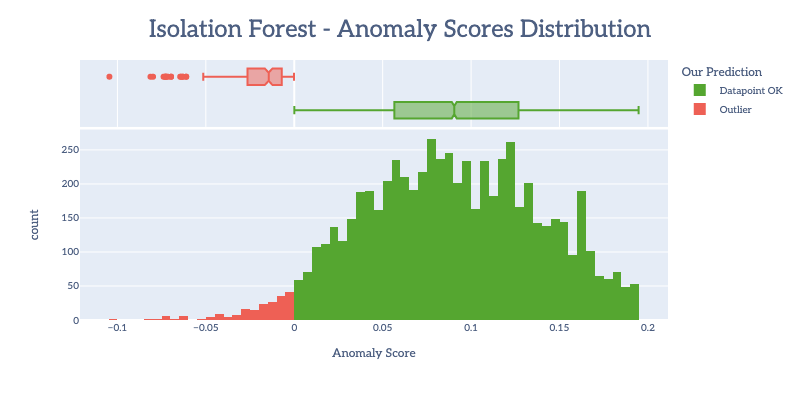

201/201 [==============================] - 0s 1ms/step


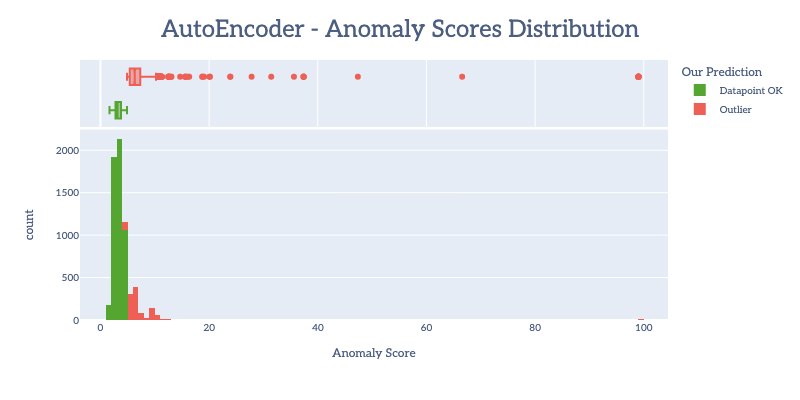

In [77]:
for model, predictions, name in zip([isolation_forest, ae], [prediction_if, prediction_ae], ['Isolation Forest', 'AutoEncoder']):
    histogram = pd.DataFrame()
    histogram['anomaly_score'] = model.decision_function(bergpieper_test)
    histogram['error_detected'] = predictions
    histogram['error_detected'] = histogram['error_detected'].replace({0:'Datapoint OK', 1: 'Outlier'})
    fig = px.histogram(histogram, x='anomaly_score', 
                    nbins=100, marginal='box', 
                    color='error_detected', 
                    color_discrete_sequence=['#55a630', '#ee6055'],
                    labels={'anomaly_score': 'Anomaly Score', 'error_detected': 'Error Detected'})
    fig.update_layout(font=dict(family="Aleo", size=10, color="#4d5f81"),
                      title=dict(x=0.5, y=0.95, font=dict(size=24), text=name+ " - Anomaly Scores Distribution", xanchor='center'),
                      legend_title_text='Our Prediction',
                      width=800, height=400)
    fig.show()

## 4. Takeaway - Initial performance assessment of the models
The Shapley analysis as well as the visual assessments reveal that all three models operate differently, prioritize distinct features, and yield varying results. This variability can be attributed to both the internal workings of the models and the non-optimized hyperparameters. 

In the case of the water pipits under consideration, the DBSCAN algorithm appears, upon initial assessment, to be the most suitable. It recognizes the trumpet shape of the temporally conditioned altitude migration of water pipits and exhibits a somewhat high but still plausible outlier rate of 6%. The AutoEncoder, on the other hand, demonstrates a very high outlier rate (17.9%), which could potentially be mitigated through hyperparameter analysis. Moreover, it is preferable to detect too many outliers and tolerate a few false positives to mitigate false negatives. Upon examining the pair plots, the Isolation Forest, despite its simplicity, identifies valid outliers; still, similar to the AutoEncoder, it only partially captures date-related outliers.

However, a valid assessment of the suitability of the algorithms can only be made after a comprehensive evaluation with ground truth labels.

# 
<p style="background-color:#4A3228;color:white;font-size:240%;border-radius:10px 10px 10px 10px;"> &nbsp; 7️⃣ Outlook </p>
In this notebook, we prepared the data for outlier analysis using machine learning algorithms and trained corresponding models - DBSCAN, Isolation Forest, and an AutoEncoder.

We further conducted a Shap analysis and an initial visual assessment, revealing that all three models function distinctively. Upon initial evaluation, the DBSCAN algorithm appears to be the most suitable for the water pipit.

A comprehensive evaluation of the suitability for our bird dataset, including other bird species, can only be performed upon obtaining access to the labels of the test data. Upon receipt, we will provide a notebook in Chapter *03_evaluation* for an in-depth analysis of the models and assess whether the methodology employed is suitable for detecting implausible bird sightings.